# Lab:  Neural Networks for Music Classification

In addition to the concepts in the demo for this unit, in this lab, you will learn to:
* Load a file from a URL
* Extract simple features from audio samples for machine learning tasks such as speech recognition and classification
* Build a simple neural network for music classification using these features
* Use a callback to store the loss and accuracy history in the training process
* Optimize the learning rate of the neural network

To illustrate the basic concepts, we will look at a relatively simple music classification problem.  Given a sample of music, we want to determine which instrument (e.g. trumpet, violin, piano) is playing.  This dataset was generously supplied by [Prof. Juan Bello](http://steinhardt.nyu.edu/faculty/Juan_Pablo_Bello) at NYU Stenihardt  and his former PhD student Eric Humphrey (now at Spotify).  They have a complete website dedicated to deep learning methods in music informatics:

http://marl.smusic.nyu.edu/wordpress/projects/feature-learning-deep-architectures/deep-learning-python-tutorial/

You can also check out Juan's <a href="http://www.nyu.edu/classes/bello/ACA.html">course</a>.



## Loading the PyTorch package

We begin by loading PyTorch and the other packages.  If you have not already installed the PyTorch package on your computer, you may need to do so.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch

## Audio Feature Extraction with Librosa

The key to accurate audio classification is to extract good features. In addition to `torch`, we will use the `librosa` package.  The `librosa` package in python has a rich set of audio feature extraction methods for machine learning tasks such as speech recognition and sound classification. 

Installation instructions and complete documentation for the package are given on the [librosa main page](https://librosa.github.io/librosa/).  After you have installed the package, you should be able to import it as follows.

In [2]:
import librosa
import librosa.display
import librosa.feature

In this lab, we will use a set of music samples from the website:

http://theremin.music.uiowa.edu

This website has great files for audio processing.  We will use the `requests.get` and `file.write` commands to load the file from a given URL into the working directory.

In [9]:
import requests
fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

req = requests.get(url)
with open(fn, "wb") as file:        
    file.write(req.content) # write to file

If the above fails, you may need to install `requests` with `conda install requests`.

Next, we'll use the `librosa` command `librosa.load` to read the audio file with filename `fn` and get the samples `y` and sample rate `sr`.

In [10]:
fn = "SopSax.Vib.pp.C6Eb6.aiff"
y, sr = librosa.load(fn)

Let's play the audio file.  You should hear a soprano saxaphone playing four notes (C, C#, D, Eb).

In [12]:
# TODO: play audio file using IPython.display (recall the lab from unit 6)
import IPython.display as ipd
ipd.Audio(y, rate=sr)

Extracting features from audio files is an entire subject on its own right.  A commonly used set of features are called the Mel Frequency Cepstral Coefficients (MFCCs).  These are derived from the so-called "mel" spectrogram, which represents both frequency and power in the log domain.  This is motivated by human perceptual processing, which does something similar.  The code below displays the mel spectrogram of the audio sample.

The spectrogram clearly shows the four notes played in the audio track.  It also shows the "harmonics" of each note, which are the frequency components at integer multiples of the fundamental frequency of each note.

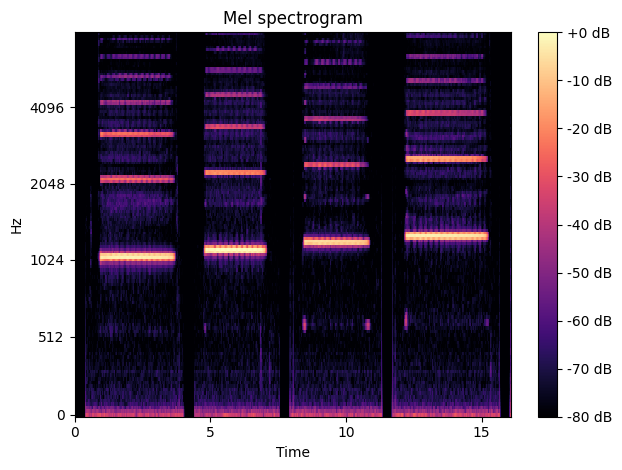

In [13]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

## Downloading the Data

Using the MFCC features described above, Eric Humphrey and Juan Bellow have created a complete data set that can used for instrument classification.  Essentially, they collected a number of data files from the website above and, for each audio file, they segmented the track into notes and then extracted 120 MFCCs for each note.  The goal was to recognize the instrument from the 120 MFCCs.  The process of feature extraction is quite involved.  So, we will just use their processed data provided at:

https://github.com/marl/dl4mir-tutorial/blob/master/README.md

Note the password.  Load the four files into some directory, say, `instrument_dataset`.  Then, load the data into numpy arrays as follows.

In [15]:
data_dir = 'instrument_dataset/'
Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

From these data files, write code that prints out:
* the number of training and test samples
* the number of features in each sample
* the number of classes (i.e., instruments to recognize)

In [18]:
# TODO
print('Num training = %d'%Xtr.shape[0])
print('Num test = %d'%Xts.shape[0])
print('Num features = %d' % Xtr.shape[1])
print('Num classes = %d' % (np.max(ytr) + 1))

Num training = 66247
Num test = 14904
Num features = 120
Num classes = 10


Before continuing, we will standardize the training and test data, `Xtr` and `Xts`.  First compute the mean and std deviation of each feature in `Xtr`.  Then create a new training data set, `Xtr_scale`, by subtracting the feature means from `Xtr` and dividing by the feature std deviations.  Then create a standardized test dataset, `Xts_scale`, **using the mean and std deviation computed on the training dataset**.

In [23]:
# TODO Scale the training and test matrices
mean = np.mean(Xtr,axis=0).reshape(1, -1)
std = np.std(Xtr,axis=0).reshape(1, -1)
Xtr_scale = (Xtr-mean) / std
Xts_scale = (Xts-mean) / std

## Create DataLoaders

To use PyTorch, we first create a Dataloader using the `TensorDataset` and `DataLoader` commands, just as in the demos. We will use `batch_size = 100`.

In [24]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 100

# TODO Convert the numpy arrays to tensors
Xtr_torch = torch.Tensor(Xtr_scale)
ytr_torch = torch.Tensor(ytr)
Xts_torch = torch.Tensor(Xts_scale)
yts_torch = torch.Tensor(yts)

# TODO Create a training/test dataset from the tensors
train_ds = TensorDataset(Xtr_torch, ytr_torch)
test_ds = TensorDataset(Xts_torch, yts_torch)


# TODO Create a training/test data loader from datasets
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=batch_size) 

## Building a Neural Network Classifier

Following the example in [MNIST neural network demo](./mnist_neural.ipynb), create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation

Make sure to select the input and output dimensions correctly, and print the model summary.

In [26]:
import torch.nn as nn

n_in = Xtr.shape[1]
n_out = np.max(ytr) + 1
n_hidden = 256


class Net(nn.Module):
    def __init__(self,n_in, n_hidden, n_out):
        super(Net, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.layer1 = nn.Linear(n_in, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_out)
        
    def forward(self, x):
        x = self.sigmoid(self.layer1(x))
        out = self.layer2(x)
        return out

model = Net(n_in=n_in, n_hidden=n_hidden, n_out=n_out)
print(model)

Net(
  (sigmoid): Sigmoid()
  (layer1): Linear(in_features=120, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=10, bias=True)
)


## Training the Network

Next, select an optimizer (linked to the parameters of your new model) and a loss function. For the optimizer, we suggest to start with the Adam optimizer with a learning rate of 0.001.

In [27]:
import torch.optim as optim

lr = 1e-3

# TODO
opt = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

Train the model for 10 epochs using the scaled training data.  For **every batch**, record the training loss. 
For **every epoch**, record the training accuracy, the test loss, and the test accuracy.  Use the variable names defined below.  The code should be similar to that in the MNIST demo.

In [31]:
# TODO Train model for 10 epochs

a_tr_loss = []
a_tr_accuracy = []
a_ts_loss = []
a_ts_accuracy = []

for epoch in range(10):
    total = 0
    correct = 0
    for i, data in enumerate(train_loader):
        x, y = data
        y = y.type(torch.long)
        out = model(x)
        loss = criterion(out, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        a_tr_loss.append(loss.item())
        _, predicted = torch.max(out.data, 1)
        total += y.shape[0]
        correct += (predicted == y).sum().item()
    a_tr_accuracy.append(correct / total)
    with torch.no_grad():
        total = 0
        correct = 0
        for i, data in enumerate(test_loader):
            x, y = data
            y = y.type(torch.long)
            out = model(x)
            loss = criterion(out, y)
            a_ts_loss.append(loss.item())
            _, predicted = torch.max(out.data, 1)
            total += y.shape[0]
            correct += (predicted == y).sum().item()
        a_ts_accuracy.append(correct / total)
    print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
          +'Train Accuracy: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
          +'Test Accuracy: {0:.2f}'.format(a_ts_accuracy[epoch]))

Epoch:  1   Train Loss: 2.281   Train Accuracy: 0.89    Test Loss: 0.142   Test Accuracy: 0.96
Epoch:  2   Train Loss: 2.194   Train Accuracy: 0.98    Test Loss: 0.215   Test Accuracy: 0.97
Epoch:  3   Train Loss: 2.072   Train Accuracy: 0.99    Test Loss: 0.159   Test Accuracy: 0.98
Epoch:  4   Train Loss: 2.003   Train Accuracy: 0.99    Test Loss: 0.193   Test Accuracy: 0.99
Epoch:  5   Train Loss: 1.893   Train Accuracy: 0.99    Test Loss: 0.168   Test Accuracy: 0.99
Epoch:  6   Train Loss: 1.883   Train Accuracy: 0.99    Test Loss: 0.127   Test Accuracy: 0.99
Epoch:  7   Train Loss: 1.751   Train Accuracy: 0.99    Test Loss: 0.147   Test Accuracy: 0.99
Epoch:  8   Train Loss: 1.836   Train Accuracy: 1.00    Test Loss: 0.057   Test Accuracy: 0.99
Epoch:  9   Train Loss: 1.721   Train Accuracy: 1.00    Test Loss: 0.034   Test Accuracy: 0.99
Epoch: 10   Train Loss: 1.732   Train Accuracy: 1.00    Test Loss: 0.148   Test Accuracy: 0.99


Plot the test accuracy versus epoch, as saved in `a_ts_accuracy`. You should see a final accuracy $> 99\%$.

Text(0, 0.5, 'Test accuracy')

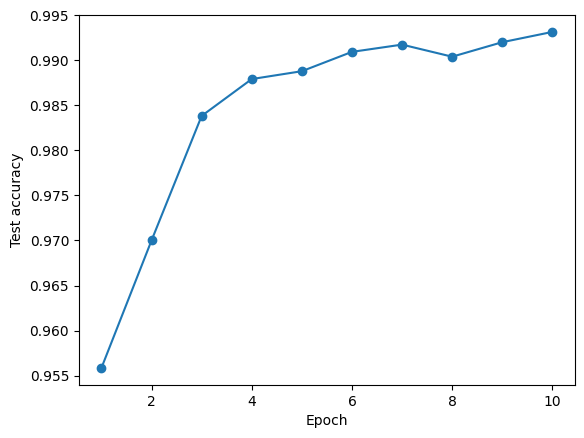

In [32]:
# TODO
plt.plot(np.arange(1, 11), a_ts_accuracy, 'o-')
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')

Plot the loss **versus batch**, as saved in `a_tr_loss`, using `semilogy`.  But label the x-axis in units of epochs.  Note that the relation between the epoch and batch index `i` is `epoch = i*batch_size/ntr`, given `batch_size` and a total of `ntr` training samples.

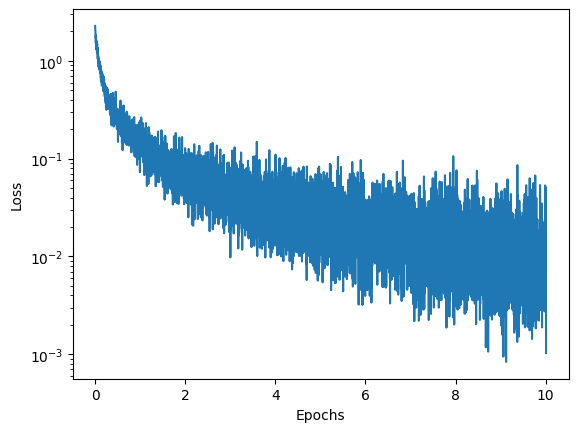

In [34]:
# TODO
n_steps = len(a_tr_loss)
n_tr = Xtr.shape[0]
epochs = np.arange(1, n_steps + 1) * batch_size / n_tr
plt.semilogy(epochs, a_tr_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Optimizing the Learning Rate

One challenge in training neural networks is the selection of the learning rate.  Re-run the above code inside a for loop that trys the 3 learning rates given in the vector `rates`.  For each learning rate:
* instantiate the model (which resets the learned parameters),
* construct the optimizer (i.e., Adam with the appropriate learning rate),
* train the model,
* record the loss versus batch and accuracy versus epoch, as before.

In [35]:
rates = [0.01,0.001,0.0001]
loss_hist = []
val_acc_hist = []

# TODO
for lr in rates:
    model = Net(n_in=n_in, n_hidden=n_hidden, n_out=n_out)

    opt = optim.Adam(model.parameters(), lr=lr)

    a_tr_loss = []
    a_tr_accuracy = []
    a_ts_loss = []
    a_ts_accuracy = []

    for epoch in range(10):
        total = 0
        correct = 0
        for i, data in enumerate(train_loader):
            x, y = data
            y = y.type(torch.long)
            out = model(x)
            loss = criterion(out, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            a_tr_loss.append(loss.item())
            _, predicted = torch.max(out.data, 1)
            total += y.shape[0]
            correct += (predicted == y).sum().item()
        a_tr_accuracy.append(correct / total)
        with torch.no_grad():
            total = 0
            correct = 0
            for i, data in enumerate(test_loader):
                x, y = data
                y = y.type(torch.long)
                out = model(x)
                loss = criterion(out, y)
                a_ts_loss.append(loss.item())
                _, predicted = torch.max(out.data, 1)
                total += y.shape[0]
                correct += (predicted == y).sum().item()
            a_ts_accuracy.append(correct / total)
        print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
              +'Train Accuracy: {0:.2f}    Test Loss: {1:.3f}   '.format(a_tr_accuracy[epoch], a_ts_loss[epoch])
              +'Test Accuracy: {0:.2f}'.format(a_ts_accuracy[epoch]))
    loss_hist.append(a_tr_loss)
    val_acc_hist.append(a_ts_accuracy)
    
    # Print the final accuracy
    print("lr=%12.4e test accuracy=%f" % (lr, a_ts_accuracy[-1]))

Epoch:  1   Train Loss: 2.349   Train Accuracy: 0.96    Test Loss: 0.050   Test Accuracy: 0.98
Epoch:  2   Train Loss: 1.994   Train Accuracy: 0.99    Test Loss: 0.204   Test Accuracy: 0.99
Epoch:  3   Train Loss: 2.059   Train Accuracy: 0.99    Test Loss: 0.154   Test Accuracy: 0.98
Epoch:  4   Train Loss: 1.764   Train Accuracy: 0.99    Test Loss: 0.077   Test Accuracy: 0.98
Epoch:  5   Train Loss: 1.292   Train Accuracy: 0.99    Test Loss: 0.058   Test Accuracy: 0.99
Epoch:  6   Train Loss: 1.453   Train Accuracy: 1.00    Test Loss: 0.140   Test Accuracy: 0.99
Epoch:  7   Train Loss: 1.337   Train Accuracy: 1.00    Test Loss: 0.082   Test Accuracy: 0.99
Epoch:  8   Train Loss: 1.231   Train Accuracy: 1.00    Test Loss: 0.012   Test Accuracy: 0.99
Epoch:  9   Train Loss: 1.111   Train Accuracy: 1.00    Test Loss: 0.004   Test Accuracy: 0.98
Epoch: 10   Train Loss: 0.977   Train Accuracy: 1.00    Test Loss: 0.057   Test Accuracy: 0.99
lr=  1.0000e-02 test accuracy=0.988124
Epoch:  1  

Plot the loss vs. batch index (again labeling the x-axis in units of epochs) for all three learning rates on one graph.  You should see that, at a lower learning rate, the loss is more stable but converges more slowly.

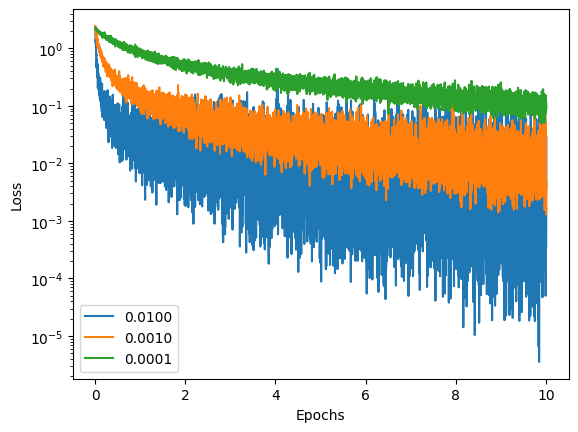

In [36]:
# TODO
ntest = len(loss_hist)
ntr = Xtr.shape[0]
batch_size=100
for it, loss in enumerate(loss_hist):
    nsteps = len(loss)
    epochs = np.arange(1, 1+nsteps)* batch_size / ntr
    plt.semilogy(epochs, loss)
    rate_str = ['{0:5.4f}'.format(lr) for lr in rates]

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(rate_str)